In [11]:
# Import libraries
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split

import matplotlib
from matplotlib import pyplot as plt
try:
    import seaborn as sns
    use_seaborn = True
    sns.set()
except:
    use_seaborn = False

showfig = True
delOutliers = True
downSizing  = True

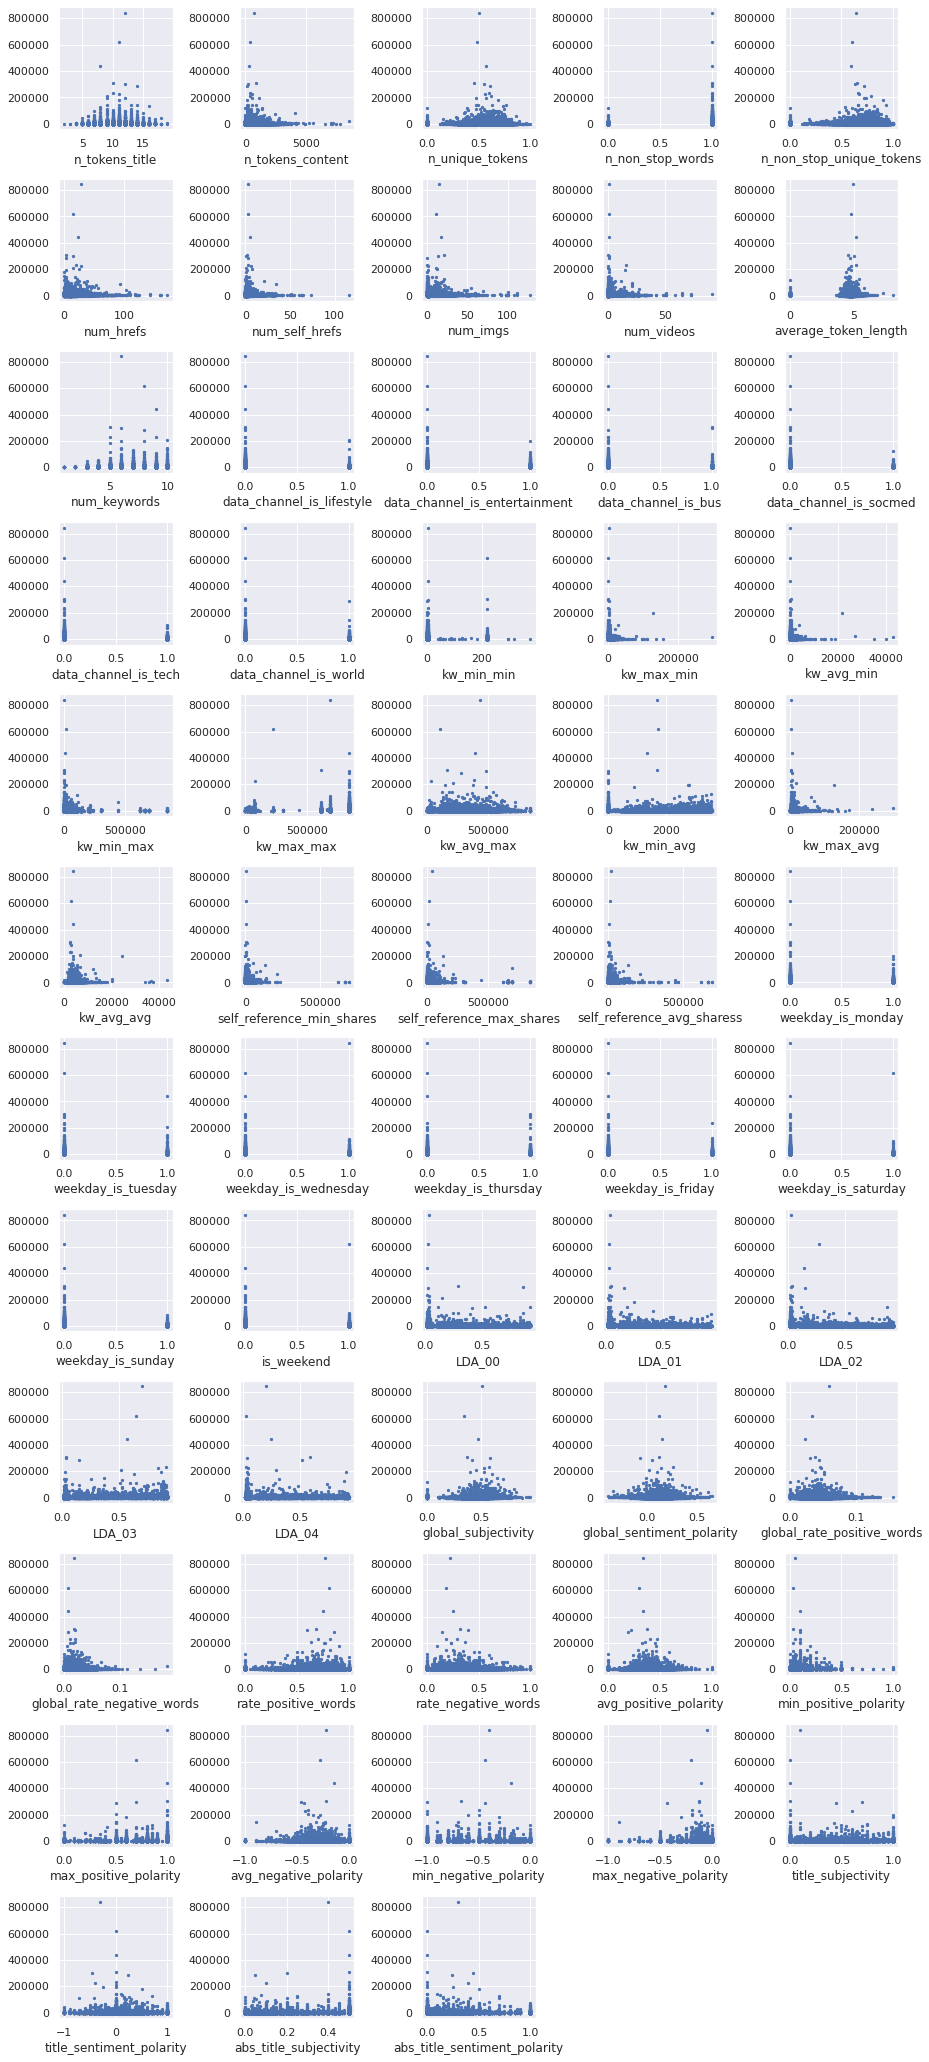

In [12]:
X1 = pd.read_csv("X1.csv")
Y1 = pd.read_csv("Y1.csv",header=None,names =['shares'])

if showfig:
    fig = plt.figure(figsize=(6.4*2,4.8*6))
    gs  = fig.add_gridspec(nrows=12, ncols=5)
    for (i,header) in enumerate(X1.columns):
        ax = fig.add_subplot(gs[int(i/5),i%5])
        ax.scatter(X1[header],Y1.values, s=5)
        ax.set_xlabel(header)
    fig.tight_layout()

X1_val = X1.values
Y1_val = Y1.values

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1_val, Y1_val,random_state=1, test_size=0.2)

In [3]:
# Prediction
def scoref1(ytrue, ypred, th):
    return sklearn.metrics.f1_score(ytrue>th, ypred>th)

def scoreregression(ytrue, ypred):
    scores = [
        scoref1(ytrue, ypred, th=th) for th in [ 500, 1400, 5000, 10000]
    ]
    return np.mean(scores)

In [14]:
if downSizing:
    # corr = np.corrcoef(X1_train)
    # corr = np.triu(corr) - np.eye(corr.shape[0]) #np.diag(np.diag(corr))
    # delt = np.where(corr>1-1e-7)

    # keep = np.where([idx not in delt[0] for idx in range(corr.shape[0])])[0]
    # print(X1_val.shape[0], len(keep))

    # X1_train,Y1_train = X1_train[keep,:],Y1_train[keep,:]
    
    corr = np.corrcoef(X1_val.transpose())
    corr = np.triu(corr) - np.eye(corr.shape[0]) #np.diag(np.diag(corr))
    delt = np.where(corr>1-1e-1)

    keep = np.where([idx not in delt[0] for idx in range(corr.shape[0])])[0]
    print(X1_val.shape[1], len(keep))

    X1_val = X1_val[:,keep]

58 55


In [15]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1_val, Y1_val,random_state=1, test_size=0.2)

In [16]:
from sklearn import linear_model

# Select features
corr = np.corrcoef(np.concatenate((np.transpose(X1_train),np.transpose(Y1_train))))
# idxs = np.argpartition(corr[:-1][-1], -4)[-4:]
idxs = np.argsort(corr[-1][:-1])[-5:]
X1_train_ = X1_train[:,idxs]
X1_test_  = X1_test[:,idxs]

# Create linear regression object
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(X1_train_, Y1_train)
# Make predictions using the testing set
Y1_pred = regr.predict(X1_test_)

print(scoreregression(Y1_test, Y1_pred))

0.4757223191683778


In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

# Initiate StandardScaler
scaler = StandardScaler(copy=True,with_mean=True,with_std=True)
X1_normalized = scaler.fit_transform(X1_train)
X1_ = X1_normalized.copy()

# Initialize PCA
pca = PCA(n_components=X1.shape[-1])

data_transformed = pca.fit_transform(X1_, Y1_train)
eig_val = pca.explained_variance_
eig_vec = pca.components_

# Compute an array E, where E(P) indicates the variance captured in the first P component.
E = np.array([eig_val[:p+1].sum()/eig_val.sum() for p in range(len(eig_val))])
tau = 0.95 # Threshold

# Find the minimum P that captures \tau portion of the variance
P = np.where(E>tau)[0][0] +1
print('Minimum number of components that preserve {} of the variance = {} \n' .format(tau,P))

if showfig:
    fig = plt.figure(figsize=(20,5))
    ax1 = fig.add_subplot() #(131)
    ax1.plot(np.arange(1,E.shape[0]+1), E, 'o-', markersize=8, color='blue', alpha=0.5)
    ax1.set_xlabel('number of components')
    ax1.set_ylabel('Preserved variance')

Minimum number of components that preserve 0.95 of the variance = 36 



In [7]:
pca.n_components = 5
X1_ = X1_normalized.copy()
X1_train_ = pca.fit_transform(X1_, Y1_train)
X1_test_  = pca.fit_transform(
                scaler.fit_transform(X1_test))

knn = KNeighborsRegressor(20)
# knn.fit(X1_train_, Y1_train.ravel())
knn.fit(X1_train_, Y1_train)
Y1_pred = knn.predict(X1_test_)
print(scoreregression(Y1_test, Y1_pred))

0.4865565907502706


In [8]:
#https://towardsdatascience.com/deep-neural-multilayer-perceptron-mlp-with-scikit-learn-2698e77155e
from sklearn.neural_network import MLPRegressor

pca.n_components = 5
X1_ = X1_normalized.copy()
X1_train_ = pca.fit_transform(X1_, Y1_train)
X1_test_  = pca.fit_transform(
                scaler.fit_transform(X1_test))

reg = MLPRegressor(hidden_layer_sizes=(64,64,64),
                   activation="relu",
                   random_state=1,
                   max_iter=100)
reg.fit(X1_train_, Y1_train.ravel())
Y1_pred = reg.predict(X1_test_)
print(scoreregression(Y1_test, Y1_pred))

0.48093762720060984


/media/gregoire/WD Elements 10B8/studies/MA/lelec2870_machine_learning/Sessions/myenv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [9]:
# scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
# ++ CHOOSE BEST PARAMETERS TO FIT
#     scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.svm import SVC

# pca.n_components = 5
scaler = StandardScaler()

X1_train_ = scaler.fit_transform(X1_train)
X1_test_  = scaler.fit_transform(X1_test)

# X1_train_ = pca.fit_transform(scaler.fit_transform(X1_train), Y1_train)
# X1_test_  = pca.fit_transform(scaler.fit_transform(X1_test))

svc = SVC(C=10,
          gamma='auto',
          max_iter=500)
svc.fit(X1_train_, Y1_train.ravel())
Y1_pred = svc.predict(X1_test_)
print(scoreregression(Y1_test, Y1_pred))

/media/gregoire/WD Elements 10B8/studies/MA/lelec2870_machine_learning/Sessions/myenv/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


0.42685217539195025
